<a href="https://www.kaggle.com/code/rohankaman12/stock-market-prediction-by-multiple-models?scriptVersionId=179758120" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

The stock market is the cornerstone of world business and finance, with its fluctuations dictating the movement of trillions of dollars every instant. Traders, investors, and financial analysts continuously seek advanced methods to forecast market trends and enhance their decision-making processes. This project aims to leverage the power of both traditional statistical models and cutting-edge machine learning techniques to predict stock market prices with historical data. Utilising Python's yfinance library, this study will extract historical stock data to feed into three distinct predictive models: Random Forest, XGBoost, and Long Short-Term Memory (LSTM). Each model offers unique strengths in handling time-series data, which will be explored and evaluated for their predictive accuracy and practical applicability. The ultimate goal is to compare these models' performance and identify the most effective approach for real-time stock market prediction, providing an additional source of information for individual investors. Of course, the stock market is influenced by millions of different factors, meaning a one-to-one prediction of the future solely using historical data is virtually impossible. However, this project's success will be determined by its ability and accuracy to utilise historical data for predictions. I will be using the NASDAQ's "Magnificent Seven", which are Alphabet, Amazon, Apple, Meta Platforms, Microsoft, Nvidia, and Tesla. The ultimate goal of this project is to be able to make accurate predictions of historical data using machine learning models. The techniques demonstrated here can be applied to a variety of predictive tasks across different domains. This project showcases the application of machine learning and AI knowledge, and how these techniques can be leveraged for real-world problems.

## Imports

Below, I will import all of the libraries necessary to run this project.

In [1]:
!pip install yfinance
!pip install xgboost
!pip install keras-tuner
!pip install tf-explain
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import keras_tuner as kt
from keras.optimizers import Adam
from tf_explain.core.integrated_gradients import IntegratedGradients
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotUniform
import random
import os

# Set the random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Set seed for Python's hash function to ensure reproducibility across different runs
os.environ['PYTHONHASHSEED'] = '42'
#This code is for implementing my GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices('GPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU: " + str(tpu.master()))
elif len(gpus) > 0:
    strategy = tf.distribute.MirroredStrategy(gpus)
    print("Running on ",len(gpus)," GPU(s)")
else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293378 sha256=b5734a038ef6a4a971bd81ead35d88a449ad73755e58de3af52a8c132ecc2907
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00


2024-05-25 22:07:06.310060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 22:07:06.310167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 22:07:06.429546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running on  1  GPU(s)


# Exploratory Data Analysis and Initial Visualisations
First, I want to visualise some data. This will allow me to better understand how to build my models and what exactly I'm working with.

## Fetching Data
Here, I'll fetch the market data for the Magificent Seven.

In [2]:
ticker_symbols = ['GOOGL', 'AMZN', 'AAPL', 'META', 'MSFT', 'NVDA', 'TSLA']

dataframes = {}

for ticker in ticker_symbols:
    # Download the stock data
    ticker_data = yf.download(ticker, start='2020-01-01')
    
    # Add a suffix to each column name to identify it by ticker
    ticker_data = ticker_data.add_suffix(f'_{ticker}')
    
    dataframes[ticker] = ticker_data

# Combine all the dataframes into a single dataframe
combined_df = pd.concat(dataframes.values(), axis=1, keys=ticker_symbols)

print(combined_df.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                GOOGL                                                    \
           Open_GOOGL High_GOOGL  Low_GOOGL Close_GOOGL Adj Close_GOOGL   
Date                                                                      
2020-01-02  67.420502  68.433998  67.324501   68.433998       68.433998   
2020-01-03  67.400002  68.687500  67.365997   68.075996       68.075996   
2020-01-06  67.581497  69.916000  67.550003   69.890503       69.890503   
2020-01-07  70.023003  70.175003  69.578003   69.755501       69.755501   
2020-01-08  69.740997  70.592499  69.631500   70.251999       70.251999   

                              AMZN                                   ...  \
           Volume_GOOGL  Open_AMZN  High_AMZN   Low_AMZN Close_AMZN  ...   
Date                                                                 ...   
2020-01-02     27278000  93.750000  94.900497  93.207497  94.900497  ...   
2020-01-03     23408000  93.224998  94.309998  93.224998  93.748497  ...   
2020-01-06     4676

## Time-Series Plot
The time series plot for each stock's closing price.

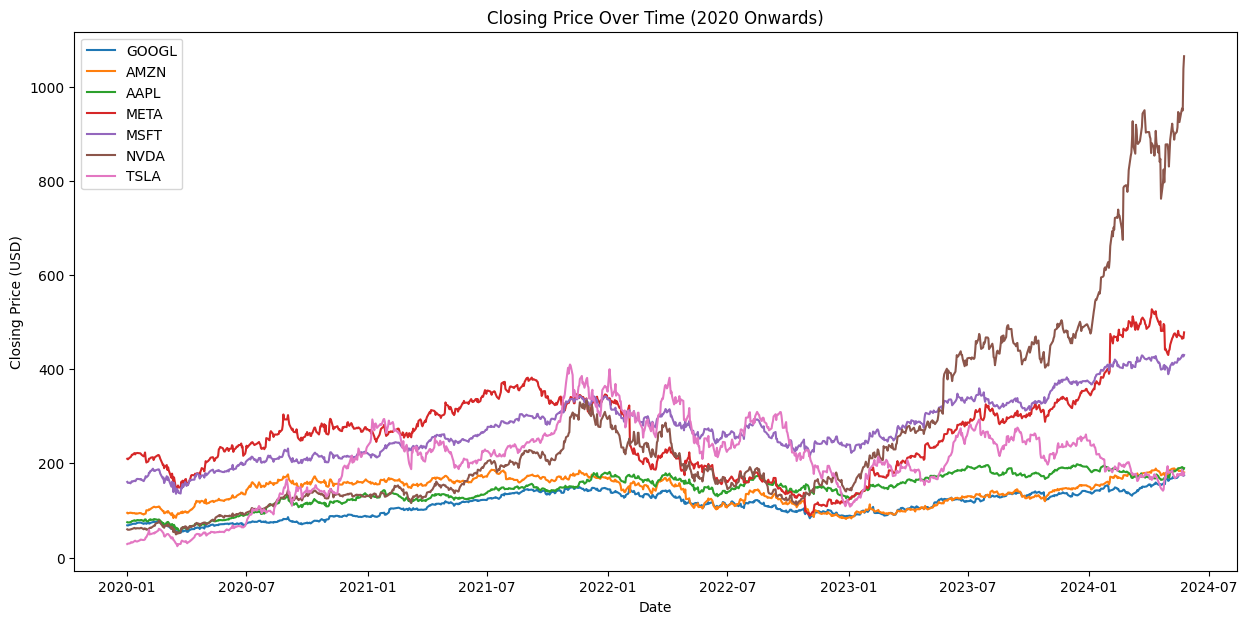

In [3]:
plt.figure(figsize=(15, 7))

for ticker in ticker_symbols:
    plt.plot(combined_df[ticker][f'Close_{ticker}'], label=ticker)
    
plt.title('Closing Price Over Time (2020 Onwards)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

There are a couple of interesting things that we can glean from this graph in regards to data preprocessing and the model. Firstly, the scale of the price changes differs significantly between stocks. For example, Tesla's rise was quire large compared to the others. This suggests a need for scaling or normalisation in preprocessing to ensure one stock's movement or higher price doesn't dominate the model's learning. Secondly, the rise of certain stocks like Nvidia could be considered an anomaly, so perhaps some anomaly detection could be useful in preprocessing the data.

## Histogram of Daily Returns
A histogram plot of the daily returns for each stock.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

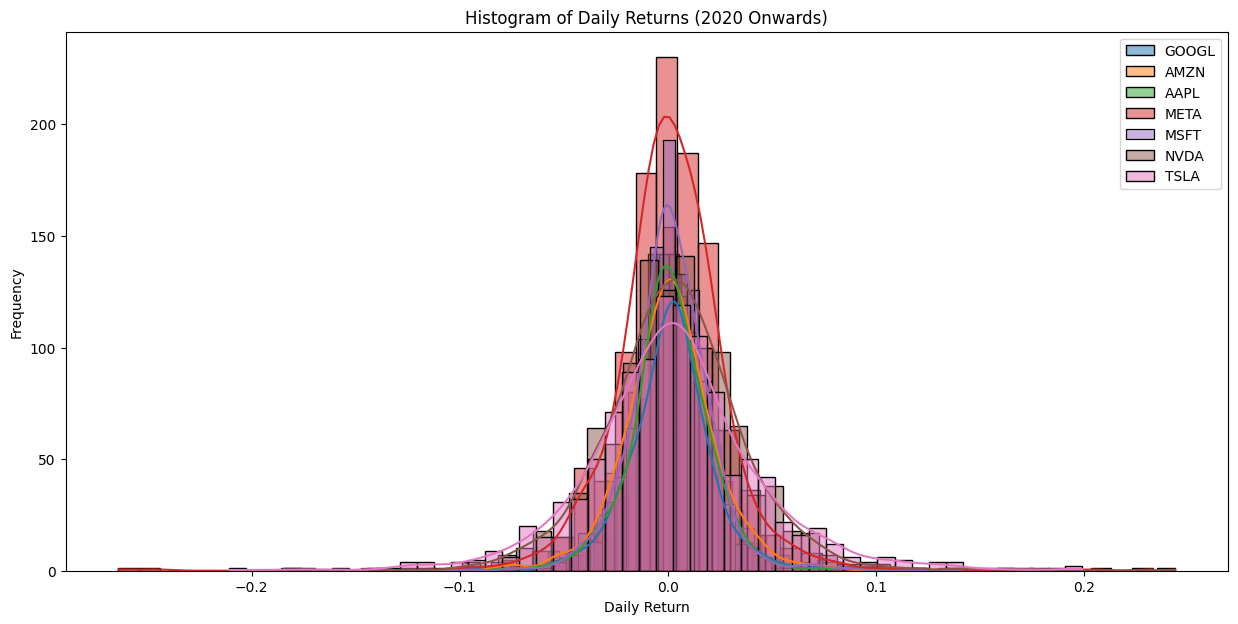

In [4]:
plt.figure(figsize=(15, 7))

for ticker in ticker_symbols:
    # Calculate daily returns
    daily_returns = combined_df[ticker][f'Close_{ticker}'].pct_change().dropna()
    sns.histplot(daily_returns, bins=50, kde=True, label=ticker)
    
plt.title('Histogram of Daily Returns (2020 Onwards)')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This histogram suggests a couple of things. First, it seems like the returns are centred around zero, which is normal. However, the tails are potentially heavier than a standard normal distribution, which could be leptokurtosis. This suggests the potential need to test for skewdness and kurtosis in the preprocessing stage to understand if it will significantly impact the data.

## Rolling Volatility Plot
A plot of the rolling volatility (standard deviation of returns) for each stock.

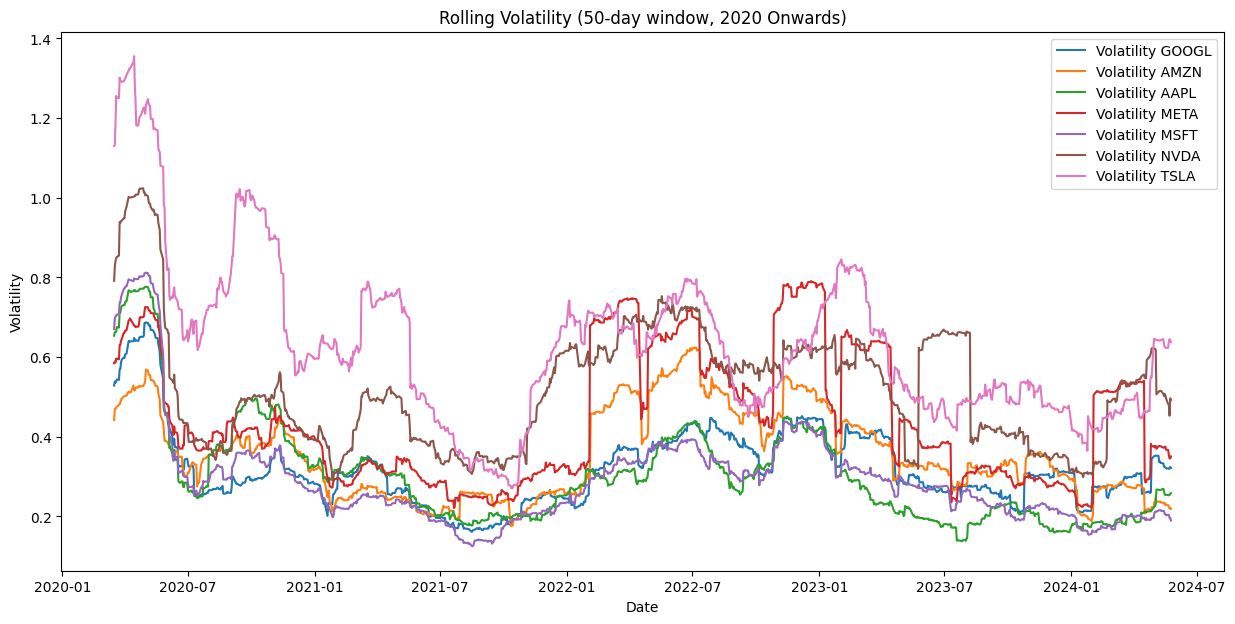

In [5]:
plt.figure(figsize=(15, 7))
rolling_window = 50  # days

for ticker in ticker_symbols:
    # Calculate daily returns
    daily_returns = combined_df[ticker][f'Close_{ticker}'].pct_change().dropna()
    # Calculate rolling volatility
    volatility = daily_returns.rolling(rolling_window).std() * (252 ** 0.5)  # Annualize the volatility
    plt.plot(volatility, label=f'Volatility {ticker}')
    
plt.title(f'Rolling Volatility (50-day window, 2020 Onwards)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

Based on the volatility graph, one additional preprocessing step that we might take is the addition of lag features. Lag features are common in time-series forcasting because they can help capture temporal dependencies and patterns that we are able to see in the volatility graph since it is a function of time.

## Correlation Heatmap
A heatmap of the correlation (daily returns) of the stocks.

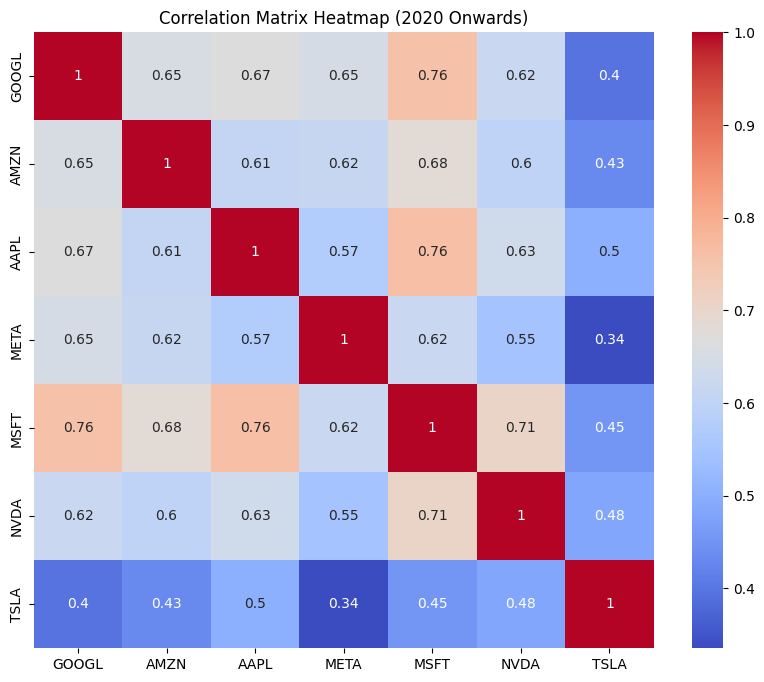

In [6]:
plt.figure(figsize=(10, 8))
returns_df = pd.DataFrame()

for ticker in ticker_symbols:
    returns_df[ticker] = combined_df[ticker][f'Close_{ticker}'].pct_change().dropna()
    
corr_matrix = returns_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap (2020 Onwards)')
plt.show()

# Data Preprocessing

Based on the above graphs, it seems like preprocessing the data is a good idea before training and testing the models for better model performance. The preprocessing steps I will take are anomaly detection, testing for skewdness and kurtosis, creating lag features, and normalization. However, to truly see whether the preprocessing will make a significant impact on my model perfomances, I'll use both a processed and unprocessed set of data to compare.

## Data Retrieval
Here, I'll retrieve the data once more and create the unfiltered dataset.

In [7]:
data = yf.download(ticker, start='2020-01-01')

# Clean the column names
data.columns = ['_'.join(col).strip() for col in data.columns.values]

unfiltered_df = data.copy()
print(unfiltered_df)

[*********************100%%**********************]  1 of 1 completed

               O_p_e_n     H_i_g_h       L_o_w   C_l_o_s_e  A_d_j_ _C_l_o_s_e  \
Date                                                                            
2020-01-02   28.299999   28.713333   28.114000   28.684000          28.684000   
2020-01-03   29.366667   30.266666   29.128000   29.534000          29.534000   
2020-01-06   29.364668   30.104000   29.333332   30.102667          30.102667   
2020-01-07   30.760000   31.441999   30.224001   31.270666          31.270666   
2020-01-08   31.580000   33.232666   31.215334   32.809334          32.809334   
...                ...         ...         ...         ...                ...   
2024-05-20  177.559998  177.750000  173.520004  174.949997         174.949997   
2024-05-21  175.509995  186.880005  174.710007  186.600006         186.600006   
2024-05-22  182.850006  183.800003  178.119995  180.110001         180.110001   
2024-05-23  181.800003  181.899994  173.259995  173.740005         173.740005   
2024-05-24  174.839996  180.

## Anomaly Detection
I will be using z-score for anomaly detection, flagging any datapoints more than 3 standard deviations away from the mean.

In [8]:
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
data_outliers = data[outliers]  # Data with anomalies
data_clean = data[~outliers]   # Data without anomalies

print(data_outliers)
print(data_clean)

               O_p_e_n     H_i_g_h       L_o_w   C_l_o_s_e  A_d_j_ _C_l_o_s_e  \
Date                                                                            
2020-01-08   31.580000   33.232666   31.215334   32.809334          32.809334   
2020-01-09   33.139999   33.253334   31.524668   32.089333          32.089333   
2020-01-13   32.900002   35.042000   32.799999   34.990665          34.990665   
2020-01-14   36.284000   36.493999   34.993332   35.861332          35.861332   
2020-01-22   38.125999   39.633331   37.273335   37.970669          37.970669   
2020-01-30   42.161331   43.391998   41.200001   42.720669          42.720669   
2020-02-03   44.912666   52.409332   44.901333   52.000000          52.000000   
2020-02-04   58.863998   64.599335   55.591999   59.137333          59.137333   
2020-02-05   54.883999   56.398666   46.940666   48.980000          48.980000   
2020-02-06   46.661331   53.055332   45.799999   49.930668          49.930668   
2020-02-13   49.456001   54.

## Testing for Skewness and Kurtosis
Now, I will be testing for skewness and kurtosis. If necessary, transformers will be applied.

In [9]:
# Calculate the skewness and kurtosis before the transformation
original_skewness = data_clean.skew()
original_kurtosis = data_clean.kurtosis()

# Apply the transformation (for demonstration, we're using log1p on columns with skewness > 1)
for column in data_clean.columns:
    if abs(original_skewness[column]) > 1:
        data_clean.loc[:, column] = data_clean.loc[:, column].astype(float)
        data_clean.loc[:, column] = np.log1p(data_clean.loc[:, column])

data_clean.dropna(inplace=True)

print(data_clean.dtypes)
        
# Calculate the skewness and kurtosis after the transformation
transformed_skewness = data_clean.skew()
transformed_kurtosis = data_clean.kurtosis()

# Compare before and after values
skewness_comparison = pd.DataFrame({'Before': original_skewness, 'After': transformed_skewness})
kurtosis_comparison = pd.DataFrame({'Before': original_kurtosis, 'After': transformed_kurtosis})

# Check if the transformers were applied
# If the transformation was applied, decrease in the absolute values of skewness and kurtosis
print(skewness_comparison)
print(kurtosis_comparison)

O_p_e_n              float64
H_i_g_h              float64
L_o_w                float64
C_l_o_s_e            float64
A_d_j_ _C_l_o_s_e    float64
V_o_l_u_m_e          float64
dtype: object
                     Before     After
O_p_e_n           -0.329063 -0.329063
H_i_g_h           -0.320309 -0.320309
L_o_w             -0.348638 -0.348638
C_l_o_s_e         -0.335641 -0.335641
A_d_j_ _C_l_o_s_e -0.335641 -0.335641
V_o_l_u_m_e        1.465718  0.295152
                     Before     After
O_p_e_n           -0.087205 -0.087205
H_i_g_h           -0.072725 -0.072725
L_o_w             -0.109639 -0.109639
C_l_o_s_e         -0.081793 -0.081793
A_d_j_ _C_l_o_s_e -0.081793 -0.081793
V_o_l_u_m_e        2.024856 -0.274010


/tmp/ipykernel_25/2271777575.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18.77822582 19.40155062 18.83935819 ... 18.29640355 18.09183636
 17.99725074]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_clean.loc[:, column] = np.log1p(data_clean.loc[:, column])
/tmp/ipykernel_25/2271777575.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.dropna(inplace=True)


## Creating Lag Features (Close Column)
Now, I'll create a lag feature, being the 'close' column

In [10]:
close_columns = [col for col in data_clean.columns if 'Close' in col]

for col in close_columns:
    data_clean.loc[:, f'{col}Lag1'] = data_clean.loc[:, col].shift(1)

# Drop any rows with NaN values that were introduced by shifting
data_clean = data_clean.dropna()

print(data_clean.head())

              O_p_e_n    H_i_g_h      L_o_w  C_l_o_s_e  A_d_j_ _C_l_o_s_e  \
Date                                                                        
2020-01-02  28.299999  28.713333  28.114000  28.684000          28.684000   
2020-01-03  29.366667  30.266666  29.128000  29.534000          29.534000   
2020-01-06  29.364668  30.104000  29.333332  30.102667          30.102667   
2020-01-07  30.760000  31.441999  30.224001  31.270666          31.270666   
2020-01-10  32.119331  32.329334  31.580000  31.876667          31.876667   

            V_o_l_u_m_e  
Date                     
2020-01-02    18.778226  
2020-01-03    19.401551  
2020-01-06    18.839358  
2020-01-07    19.407361  
2020-01-10    19.085390  


## Train-Test Split
Now, I need to split both of my datasets into a training and testing set. This is so that I can test the model's accuracy on unseen data.

In [11]:
# First, I want to clean the column names
def clean_column_names(df):
    cleaned_columns = df.columns.str.replace('_', '').str.upper()
    df.columns = cleaned_columns
    return df

# Clean the column names for both DataFrames
unfiltered_df = clean_column_names(unfiltered_df)
data_clean = clean_column_names(data_clean)

print("Cleaned Unfiltered DataFrame columns:", unfiltered_df.columns)
print("Cleaned Filtered DataFrame columns:", data_clean.columns)

Cleaned Unfiltered DataFrame columns: Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ CLOSE', 'VOLUME'], dtype='object')
Cleaned Filtered DataFrame columns: Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ CLOSE', 'VOLUME'], dtype='object')


In [12]:
# Function to compute RSI
def compute_rsi(series, window):
    delta = series.diff()  # Calculate the difference between the current and previous prices
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate the average gain
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate the average loss
    rs = gain / loss  # Calculate the Relative Strength (RS)
    return 100 - (100 / (1 + rs))  # Calculate the RSI

# Function to add features
def add_features(df):
    df['MA_5'] = df['CLOSE'].rolling(window=5).mean()
    df['MA_10'] = df['CLOSE'].rolling(window=10).mean()
    df['MA_20'] = df['CLOSE'].rolling(window=20).mean()
    df['RSI'] = compute_rsi(df['CLOSE'], window=14)
    df.dropna(inplace=True)  # Drop rows with NaN values
    return df

# Add additional features
unfiltered_df = add_features(unfiltered_df)
filtered_df = add_features(data_clean)

# Define the features and target
features = ['OPEN', 'HIGH', 'LOW', 'VOLUME', 'MA_5', 'MA_10', 'MA_20', 'RSI']
target = 'CLOSE'
time_step = 10  # Define the time_step for sequence creation

# Function to create sequences for LSTM
def create_sequences(X, y, time_step):
    X_l, y_l = [], []
    for i in range(len(X) - time_step):
        X_l.append(X[i:(i + time_step)])
        y_l.append(y[i + time_step])
    return np.array(X_l), np.array(y_l)

# Initial preprocessing for unfiltered data
X_unfiltered = unfiltered_df[features]
y_unfiltered = unfiltered_df[target]

# Initial preprocessing for filtered data
X_filtered = filtered_df[features]
y_filtered = filtered_df[target]

# Splitting the unfiltered data into training and testing sets
X_train_unfiltered, X_test_unfiltered, y_train_unfiltered, y_test_unfiltered = train_test_split(
    X_unfiltered, y_unfiltered, test_size=0.2, random_state=42)

# Splitting the filtered data into training and testing sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42)

# Scaling
scaler_filtered = MinMaxScaler()
X_train_filtered_scaled = scaler_filtered.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler_filtered.transform(X_test_filtered)

# For Random Forest and XGBoost
y_train_filtered_scaled = scaler_filtered.fit_transform(y_train_filtered.values.reshape(-1, 1))
y_test_filtered_scaled = scaler_filtered.transform(y_test_filtered.values.reshape(-1, 1))

# Creating sequences for LSTM models
X_train_unfiltered_seq, y_train_unfiltered_seq = create_sequences(X_train_unfiltered.values, y_train_unfiltered.values, time_step)
X_test_unfiltered_seq, y_test_unfiltered_seq = create_sequences(X_test_unfiltered.values, y_test_unfiltered.values, time_step)

X_train_filtered_seq, y_train_filtered_seq = create_sequences(X_train_filtered_scaled, y_train_filtered_scaled, time_step)
X_test_filtered_seq, y_test_filtered_seq = create_sequences(X_test_filtered_scaled, y_test_filtered_scaled, time_step)

# Convert data types to float32 for LSTM
X_train_unfiltered_seq = X_train_unfiltered_seq.astype('float32')
y_train_unfiltered_seq = y_train_unfiltered_seq.astype('float32').reshape(-1, 1)
X_test_unfiltered_seq = X_test_unfiltered_seq.astype('float32')
y_test_unfiltered_seq = y_test_unfiltered_seq.astype('float32').reshape(-1, 1)

X_train_filtered_seq = X_train_filtered_seq.astype('float32')
y_train_filtered_seq = y_train_filtered_seq.astype('float32').reshape(-1, 1)
X_test_filtered_seq = X_test_filtered_seq.astype('float32')
y_test_filtered_seq = y_test_filtered_seq.astype('float32').reshape(-1, 1)

# Random Forest - Unfiltered Dataset
After all the preprocessing of the data, I will now create the Random Forest model, but first I'll do this using the unfiltered data. Again, the reason why I'm doing this is to compare the results to see what the effect of the preprocessing is.

### Initialising and Training Model

In [13]:
# Initialize the Random Forest Regressor
unfiltered_rf = RandomForestRegressor(random_state=42)

# Train the model on the unfiltered data
unfiltered_rf.fit(X_train_unfiltered, y_train_unfiltered)

RandomForestRegressor(random_state=42)

### Evaluate the Model

In [14]:
y_pred_unfiltered = unfiltered_rf.predict(X_test_unfiltered)

# Calculate performance metrics
mse = mean_squared_error(y_test_unfiltered, y_pred_unfiltered)
mae = mean_absolute_error(y_test_unfiltered, y_pred_unfiltered)
r2 = r2_score(y_test_unfiltered, y_pred_unfiltered)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 17.460538412728717
Mean Absolute Error (MAE): 3.1445533068245703
R^2 Score: 0.997391131389448


### Visualisation

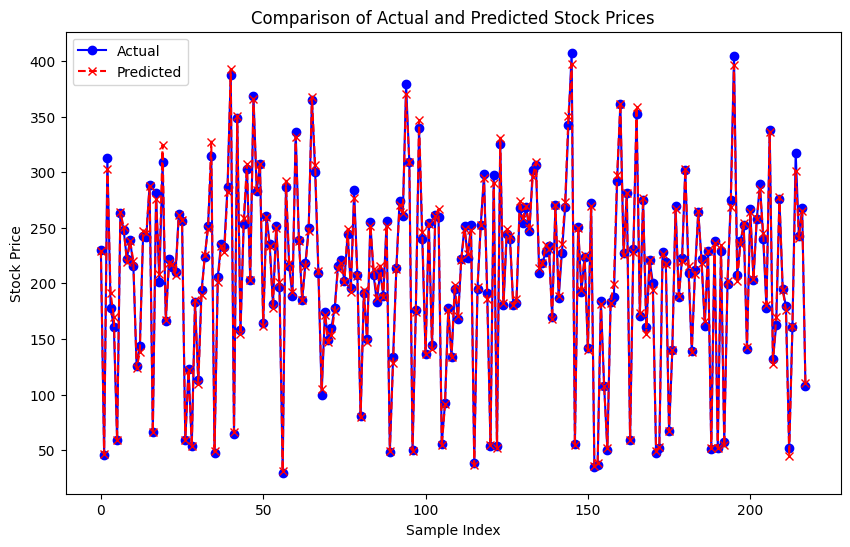

In [15]:
unfiltered_rf_results_df = pd.DataFrame({
    'Actual': y_test_unfiltered,
    'Predicted': y_pred_unfiltered
})

# Reset index to help with plotting
unfiltered_rf_results_df.reset_index(drop=True, inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(unfiltered_rf_results_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(unfiltered_rf_results_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of the Untuned Random Forest Using Unfiltered Data
The Mean Squared Error (MSE) is low, indicating that the Root Mean Squared Error (RMSE) is also low. This suggests that, on average, the model’s predictions deviate only slightly from the actual stock prices. Given that stock prices are in the hundreds, this level of error is relatively small and suggests good predictive accuracy.

The Mean Absolute Error (MAE) is also low. An average error of just a few units, in the context of stock prices ranging in the hundreds, implies that the model’s predictions are generally very close to the actual values. This further reinforces the model's accuracy and reliability.

The R² score is very high, indicating that the model explains a substantial proportion of the variance in the stock prices. While this is a strong indicator of good model performance, it is worth considering the possibility of overfitting, especially given the complex nature of stock price movements.

Also, the graph above is a simple error distribution plot. It essentially visualises the model performance and shows that for the most part, the model did a good job predicting.

### Feature Importance
Now, I can evaluate how important each feature is to fine-tune the model.

In [16]:
importances = unfiltered_rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Print the feature importance
print("Feature ranking:")
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]}")

Feature ranking:
HIGH: 0.6566515520131335
LOW: 0.3161952817146013
OPEN: 0.017901719060195432
MA_20: 0.004390739790999902
MA_5: 0.0022158961669832195
MA_10: 0.0021629753012893057
RSI: 0.00027307831695481987
VOLUME: 0.00020875763584245826


### Analysis of Feature Importance
The feature ranking analysis reveals that the most important features for predicting stock prices are the HIGH and LOW prices, with significantly higher importance scores compared to other features. This indicates that the model heavily relies on the highest and lowest prices of the stocks to make its predictions.

The OPEN price also contributes to the model but to a much lesser extent than HIGH and LOW. This suggests that the opening price is relevant but not as critical as the high and low prices for the model’s predictions.

The moving averages (MA_5, MA_10, and MA_20) have relatively low importance scores, indicating that while they are considered in the model, their impact on the predictions is minimal compared to the actual high, low, and opening prices.

The RSI and VOLUME features have the lowest importance scores, suggesting that they contribute very little to the model’s predictions. This implies that the relative strength index and trading volume are not significant factors in this specific predictive model for stock prices.

I'd also like to quickly explain MA_5, MA_10, MA_20 and RSI since they are not as self-explanatory as the other features. The moving averages (MA_5, MA_10, and MA_20) are calculated by averaging the closing prices of the stock for the last 5, 10, and 20 days, respectively. Moving averages are used to smooth out price data and identify trends over specific periods, with shorter periods (e.g., MA_5) highlighting short-term trends and longer periods (e.g., MA_20) providing a broader view. The RSI (Relative Strength Index) is a momentum oscillator that measures the speed and change of price movements, oscillating between 0 and 100 to identify overbought (above 70) or oversold (below 30) conditions. 

### Tuning Hyperparameters for the Random Forest Using Unfiltered Data
The model can be improved a bit, so by using GridSearchCV, I can systematically explore different values for hyperparameters and determine which are optimal.

In [17]:
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),  # Negated MSE for maximization
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),  # Negated MAE for maximization
    'R2': 'r2'  # R² is already a scorer that higher is better
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],             
    'max_depth': [5, 10, 20, 30, None],              
    'min_samples_split': [2, 5, 10, 15],             
    'min_samples_leaf': [1, 2, 4, 6],                
    'max_features': [None, 1.0, 'sqrt', 'log2']   
}

# Setup the grid search
grid_search = GridSearchCV(estimator = unfiltered_rf, param_grid=param_grid, cv=3,
                           scoring=scoring, refit='R2', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_unfiltered, y_train_unfiltered)

print("Best parameters for R²:", grid_search.cv_results_['params'][grid_search.best_index_])
print("Best score for R²:", grid_search.best_score_)

best_mse_index = np.argmin(grid_search.cv_results_['mean_test_MSE'])
best_mae_index = np.argmin(grid_search.cv_results_['mean_test_MAE'])

print("Best MSE score:", -grid_search.cv_results_['mean_test_MSE'][best_mse_index])
print("Best MSE parameters:", grid_search.cv_results_['params'][best_mse_index])

print("Best MAE score:", -grid_search.cv_results_['mean_test_MAE'][best_mae_index])
print("Best MAE parameters:", grid_search.cv_results_['params'][best_mae_index])

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits
Best parameters for R²: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score for R²: 0.9965101423617342
Best MSE score: 37.37400030874182
Best MSE parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 50}
Best MAE score: 4.259018050280463
Best MAE parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 50}


### Analysis of Hyperparameter Tuning for the Random Forest Using Unfiltered Data

As can be seen by the results of the above GridSearch, the "best parameters" aren't necessarily the overall best, since the default model seems pretty good compared to this. This demonstrates that the GridSearch's effectiveness depends on the range of parameter values provided. Clearly, I didn't provide enough to find the "actual" best parameters. To save computation time, I'll leave it at that since it isn't imperative that the absolute best parameters be found since this is purely for investigative purposes.

# Random Forest - Filtered Dataset
Now, it's time to train the initial random forest again. However, this time I'll be using the filtered dataset.

### Initialising and Training the Model

In [18]:
# Initialize the Random Forest Regressor
filtered_rf = RandomForestRegressor(random_state=42)

# Train the model on the filtered data
filtered_rf.fit(X_train_filtered, y_train_filtered_scaled.ravel())

RandomForestRegressor(random_state=42)

### Evaluate the Model

In [19]:
y_pred_filtered_rf = filtered_rf.predict(X_test_filtered)

# Calculate performance metrics
mse = mean_squared_error(y_test_filtered_scaled, y_pred_filtered_rf)
mae = mean_absolute_error(y_test_filtered_scaled, y_pred_filtered_rf)
r2 = r2_score(y_test_filtered_scaled, y_pred_filtered_rf)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 0.0001288487765617704
Mean Absolute Error (MAE): 0.0081744177475842
R^2 Score: 0.9970358539089011


### Visualisation

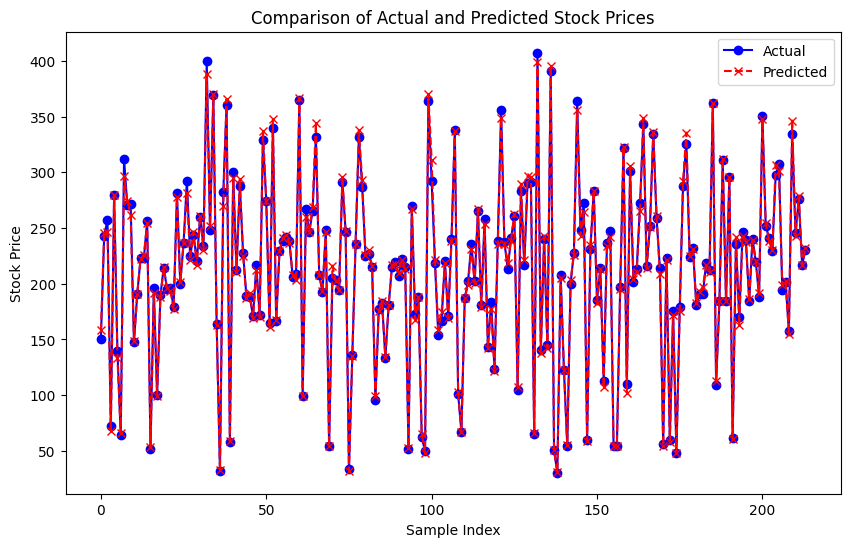

In [20]:
y_test_filtered_rescaled = scaler_filtered.inverse_transform(y_test_filtered_scaled.reshape(-1, 1)).ravel()
y_pred_filtered_rf_rescaled = scaler_filtered.inverse_transform(y_pred_filtered_rf.reshape(-1, 1)).ravel()

filtered_rf_results_df = pd.DataFrame({
    'Actual': y_test_filtered_rescaled,
    'Predicted': y_pred_filtered_rf_rescaled
})

# Reset index to help with plotting
filtered_rf_results_df.reset_index(drop=True, inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(filtered_rf_results_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(filtered_rf_results_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#### Analysis of Untuned Random Forest Using Filtered Data
The untuned random forest model using filtered data shows impressive accuracy, with low MSE and MAE values indicating very close predictions to the actual stock prices. The high R^2 score further confirms that the model explains nearly all the variance in stock prices. This level of explanatory power is excellent, particularly in financial markets where prices can be influenced by numerous unpredictable factors. However, it could also suggest potential overfitting. Additionally, there wasn't too much improvement in this department compared to the other two, but this could be due to the fact that our original R^2 score was so good.

Compared to the untuned random forest model using unfiltered data, this model performs better. This improvement highlights the effectiveness of the data preprocessing steps taken. The enhanced accuracy and explanatory power of the model with filtered data demonstrate that filtering and preparing the data before training have positively impacted the model’s performance.

### Feature Importance
Now, I can check the importance of different features. This can give me insight into the model and the data.

In [21]:
importances = filtered_rf.feature_importances_
features = X_filtered.columns

sorted_indices = np.argsort(importances)[::-1]

print("Ranked Feature Importances:")
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]}")

Ranked Feature Importances:
HIGH: 0.538261927744123
LOW: 0.43896176606004517
OPEN: 0.012858342301409142
MA_20: 0.004449643195026251
MA_10: 0.0036724728022707693
MA_5: 0.0012648849892254585
RSI: 0.00027414802772996914
VOLUME: 0.0002568148801703106


### Analysis of Feature Importance
The feature importance analysis reveals that the most significant predictors for the untuned random forest model using filtered data are the 'LOW' and 'HIGH' stock prices, indicating that the lowest and highest prices of stocks play a crucial role in predicting future stock prices.

'OPEN' stock prices also contribute meaningfully to the model's predictions, though to a lesser extent. The moving averages (MA_5, MA_20, MA_10) provide additional predictive power, demonstrating the importance of considering historical price trends in the model.

The 'RSI' and 'VOLUME' features have relatively minor importance, suggesting that the relative strength index and trading volume are less influential in this model. This ranking helps in understanding which features are most valuable for the prediction tasks and can guide further refinement and tuning of the model.

### Test for Overfitting
The metrics are really good, which means that we need to test for overfitting.

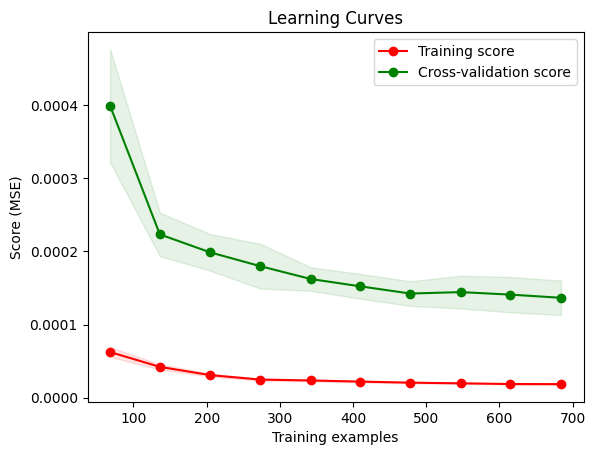

In [22]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = filtered_rf, 
    X = X_train_filtered, y = y_train_filtered_scaled.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, scoring='neg_mean_squared_error')

# Mean and Standard Deviation of training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score (MSE)')
plt.legend(loc="best")
plt.show()

### Overfitting Analysis
The two curves are converging, but there is still a noticeable gap between them. This gap suggests a mild overfitting where the model performs better on the training data than it does on unseen data, but because the cross-validation MSE decreases with more data, it shows that the model's ability to generalise is improving. However, the persistant gap indicates that some hyperparameter tuning could be necessary to improve the model performance.

### Hyperparameter Tuning
Now, I'll perform GridSearchCV like before to tune.

In [23]:
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),  # Negated MSE for maximization
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),  # Negated MAE for maximization
    'R2': 'r2'  # R² is already a scorer that higher is better
}

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': [None, 1.0]  
}

# Setup the grid search
grid_search = GridSearchCV(estimator = filtered_rf, param_grid=param_grid, cv=5,
                           scoring=scoring, refit='R2', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_filtered, y_train_filtered_scaled.ravel())

print("Best parameters for R²:", grid_search.cv_results_['params'][grid_search.best_index_])
print("Best score for R²:", grid_search.best_score_)

best_mse_index = np.argmin(grid_search.cv_results_['mean_test_MSE'])
best_mae_index = np.argmin(grid_search.cv_results_['mean_test_MAE'])

print("Best MSE score:", -grid_search.cv_results_['mean_test_MSE'][best_mse_index])
print("Best MSE parameters:", grid_search.cv_results_['params'][best_mse_index])

print("Best MAE score:", -grid_search.cv_results_['mean_test_MAE'][best_mae_index])
print("Best MAE parameters:", grid_search.cv_results_['params'][best_mae_index])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for R²: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score for R²: 0.9965050384888532
Best MSE score: 0.00015049977370920584
Best MSE parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best MAE score: 0.008709175740429448
Best MAE parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


### Analysis of Hyperparameter Tuning
As I stated before, the tuning doesn't necessarily make each metric better since there's a limited number of parameter values I can test. However, these evaluation metric numbers aren't bad in the slightest. Overall, it appears that my model's predictive power is very good and somewhat generalisable, although the concern of overfitting remains.

# XGBoost - Unfiltered Dataset
Now, let's move onto the second model, XGBoost. Like I did with the random forest,two versions of the model will be created using the unfiltered and filtered dataset respectively to evaluate the effectiveness of my preprocessing.

### Intitialising and Fitting Model

In [24]:
unfiltered_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                         max_depth = 5, alpha = 10, n_estimators = 100, random_state = 42)

unfiltered_xgb_model.fit(X_train_unfiltered, y_train_unfiltered)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

### Evaluate the Model

In [25]:
y_pred_unfiltered_xgb = unfiltered_xgb_model.predict(X_test_unfiltered)

# Calculate performance metrics
mse = mean_squared_error(y_test_unfiltered, y_pred_unfiltered_xgb)
mae = mean_absolute_error(y_test_unfiltered, y_pred_unfiltered_xgb)
r2 = r2_score(y_test_unfiltered, y_pred_unfiltered_xgb)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 29.89833355224996
Mean Absolute Error (MAE): 4.0160809088190765
R^2 Score: 0.9955327366162194


### Visualisation

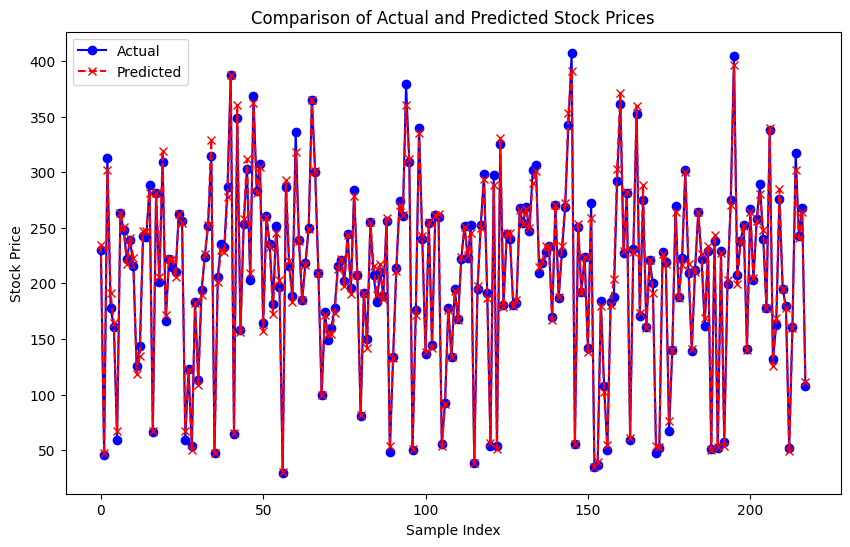

In [26]:
unfiltered_xgb_results_df = pd.DataFrame({
    'Actual': y_test_unfiltered,
    'Predicted': y_pred_unfiltered_xgb
})

# Reset index to help with plotting
unfiltered_xgb_results_df.reset_index(drop=True, inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(unfiltered_xgb_results_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(unfiltered_xgb_results_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Untuned XGBoost Using Unfiltered Data
The model seems to be performing decently well.


The Mean Squared Error (MSE) indicates that the model’s predictions have a reasonable level of error. While there is some room for improvement, the performance is still quite good considering the complexity of stock price prediction.

The Mean Absolute Error (MAE) suggests that, on average, the model’s predictions are close to the actual values. The error is relatively low, demonstrating good predictive accuracy given the data scale.

The R² score is very high, indicating that the model explains almost all of the variance in the stock prices. This high level of explanatory power is impressive, although it could also hint at potential overfitting, which is something to monitor.

Overall, these results seem promising. However, I'm a little surprised that the XGBoost model seems to be performing worse than the random forest. Perhaps this is due to the data characteristics, but I would think that in general XGBoost has an edge over random forests when it comes to predictive power. It could also be due to XGBoost needing tuning to perform better because it's more complex.

### Feature Importance
Now, I'll check for the feature importances.

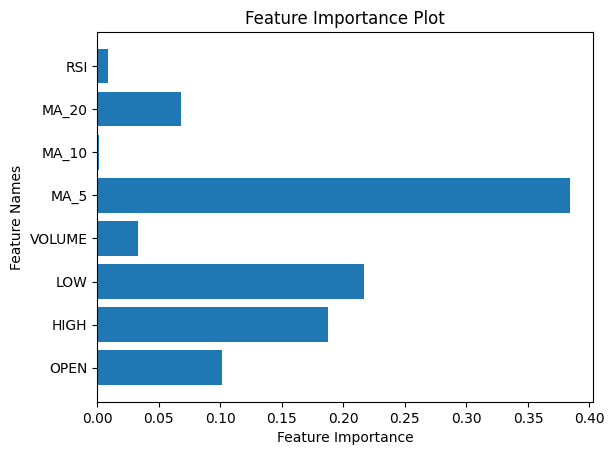

In [27]:
importance = unfiltered_xgb_model.feature_importances_
feature_names = X_unfiltered.columns

# Create a bar plot for feature importances
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Plot")
plt.show()

### Analysis of Feature Importance


The feature importance plot for the unfiltered untuned XGBoost model shows that the most critical feature for predicting stock prices is the 5-day moving average (MA_5). This feature significantly influences the model's predictions, indicating that recent price movements are highly predictive of future prices. The high and low prices also play a substantial role, reflecting the importance of daily price ranges in forecasting.

In contrast, the volume of stocks traded, the 20-day and 10-day moving averages, and the relative strength index (RSI) have a lesser impact on the model's predictions. These features, while still relevant, do not provide as much predictive power as the 5-day moving average and daily high and low prices.

This distribution of feature importance suggests that short-term price trends and daily fluctuations are the most valuable indicators for this particular model.


As a quick note, the reason why the importance of features varies from model to model is due to each model having a different interpretation and approach to utilising the features. For example, random forests are ensembles of decision trees that focus on reducing variance. Each tree in a random forest independently considers a random subset of features at each split, and the feature importance is averaged across many trees. This leads to a general, but sometimes smoothed-out, importance measure.

In contrast, XGBoost, as a gradient boosting model, builds trees sequentially, with each new tree helping to correct errors made by the previously trained trees. This method can lead to different features being emphasised if those features are particularly effective at reducing error in a sequential, additive manner. Consequently, the feature importance in XGBoost can highlight features that have a more immediate impact on improving model performance.

Therefore, the variations in feature importance between models arise from their unique mechanisms and strategies for learning from the data.

### Hyperparameter Tuning
Now, I'll tune the hyperparameters to see if the model performance can be performed. Like before, I'll be using GridSearchCV.

In [28]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.001, 0.005, 0.01, 0.02],
}

grid_search = GridSearchCV(
    estimator= unfiltered_xgb_model,
    param_grid=param_grid,
    scoring = {'MSE': mse_scorer, 'MAE': mae_scorer, 'R2': r2_scorer},
    refit='R2',  # Refit the best model based on the highest R² score
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train_unfiltered, y_train_unfiltered)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
print("Best MSE: ", -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_])
print("Best MAE: ", -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_])
print("Best R2: ", grid_search.cv_results_['mean_test_R2'][grid_search.best_index_])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_unfiltered)
print("Test MSE: ", mean_squared_error(y_test_unfiltered, y_pred))
print("Test MAE: ", mean_absolute_error(y_test_unfiltered, y_pred))
print("Test R2: ", r2_score(y_test_unfiltered, y_pred))

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.02, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.9}
Best MSE:  20.952999215161
Best MAE:  3.2819906870524087
Best R2:  0.9966213471500606
Test MSE:  17.840176958903093
Test MAE:  3.1092789763704354
Test R2:  0.9973344076468544


### Analysis of Tuned XGBoost Model on Unfiltered Data
The hyperparameter tuning improved the model in all aspects of evaluation being used (MSE, MAE, R^2). There was an improvement, but it appears that the original model parameter values weren't too bad. I wonder how the filtered XGBoost model will perform.

# XGBoost - Filtered Data
Now, I'm going to create the XGBoost model using the filtered data. I expect that the results will be better than the XGBoost model on the unfiltered data, but I can't be sure until I test it.

## Initialising and Training Model

In [29]:
filtered_xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                         max_depth = 5, alpha = 10, n_estimators = 100, random_state = 42)

filtered_xgb_model.fit(X_train_filtered, y_train_filtered_scaled.ravel())

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

## Evaluate the Model

In [30]:
y_pred_filtered_xgb = filtered_xgb_model.predict(X_test_filtered)

# Calculate performance metrics
mse = mean_squared_error(y_test_filtered_scaled, y_pred_filtered_xgb)
mae = mean_absolute_error(y_test_filtered_scaled, y_pred_filtered_xgb)
r2 = r2_score(y_test_filtered_scaled, y_pred_filtered_xgb)

# Print the performance metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 0.00468161519135623
Mean Absolute Error (MAE): 0.03905690221418232
R^2 Score: 0.8923001697044819


## Visualisation

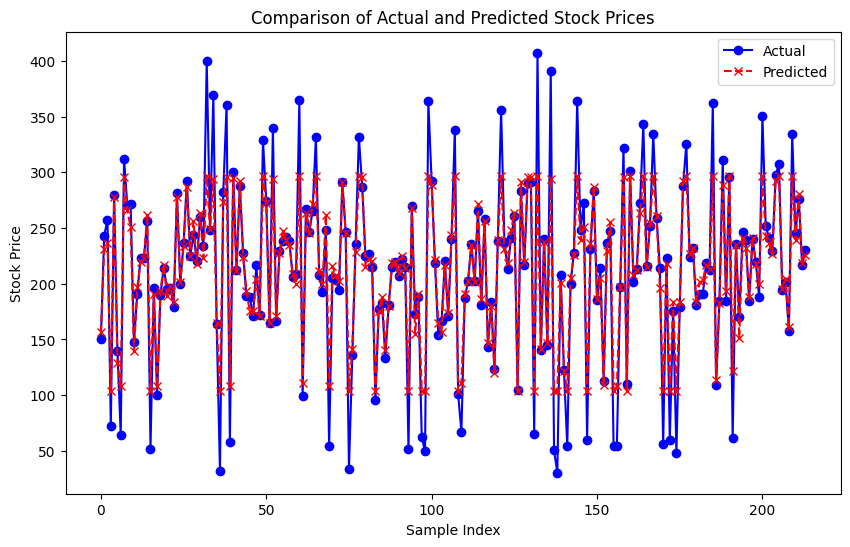

In [31]:
y_pred_filtered_xgb_rescaled = scaler_filtered.inverse_transform(y_pred_filtered_xgb.reshape(-1, 1)).ravel()

filtered_xgb_results_df = pd.DataFrame({
    'Actual': y_test_filtered_rescaled,
    'Predicted': y_pred_filtered_xgb_rescaled
})

plt.figure(figsize=(10, 6))
plt.plot(filtered_xgb_results_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(filtered_xgb_results_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Untuned XGBoost Model using Filtered Data

The Mean Squared Error (MSE) for this model indicates that, on average, the squared difference between the predicted and actual stock prices is relatively small. This suggests that the model makes accurate predictions with minimal error.

The Mean Absolute Error (MAE) shows that the average absolute difference between the predicted and actual stock prices is also low. This further confirms that the model's predictions are close to the true values, demonstrating good performance.

The R^2 score, although lower than previous models, still signifies that a substantial portion of the variance in the stock prices is explained by the model. However, it may also indicate that there is room for improvement in capturing the remaining variance. This score highlights the model's effectiveness in explaining the overall trend in the stock prices, but it might benefit from further tuning or additional features to enhance its accuracy.

However, the graph doesn't seem to reflect these strong metrics, especially compared to the random forest equivalent, so what's going on? Unlike Random Forest, which may show a more uniform distribution of errors, the errors in the XGBoost model might be more sporadic and pronounced in certain areas. This can visually amplify the perceived inaccuracies, even if the overall statistical metrics are strong. Essentially, the scatter plot may be an unflattering depiction of the imperfections in the XGBoost model. Additionally, the visualisation itself can sometimes be misleading. For instance, overlapping data points, especially in areas of high volatility, can create the appearance of greater prediction error than what the metrics indicate. The strong metrics suggest that on average, the model performs well, but individual predictions might still deviate notably from the actual values, which becomes more apparent in the visual comparison.

### Feature Importance
Now, it's time to analyse the feature importance.

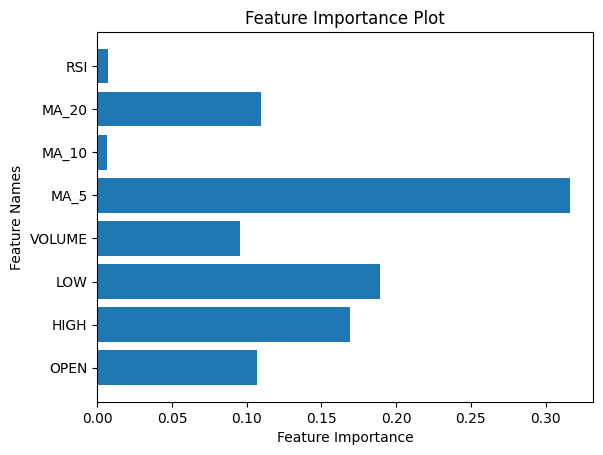

In [32]:
importance = filtered_xgb_model.feature_importances_
feature_names = X_filtered.columns

# Create a bar plot for feature importances
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Plot")
plt.show()

### Analysis of Feature Importance

The feature importance plot for the model indicates that the most influential feature is MA_5, which significantly outweighs the other features in its contribution to the model. This suggests that the short-term moving average (5 days) is a crucial indicator for predicting stock prices in this model. Following MA_5, the features LOW and HIGH also play a significant role, indicating that the daily low and high prices are important predictors. The OPEN price and MA_20 (20-day moving average) have moderate importance, while MA_10 (10-day moving average), VOLUME, and RSI (Relative Strength Index) contribute the least. This distribution highlights the model's reliance on certain price-based indicators over others, with less emphasis on trading volume and relative strength for this particular task.

### Test For Overfitting
Like I did for the random forest model trained on filtered data, checking for overfitting may be insightful to see how robust and generalisable the model is.

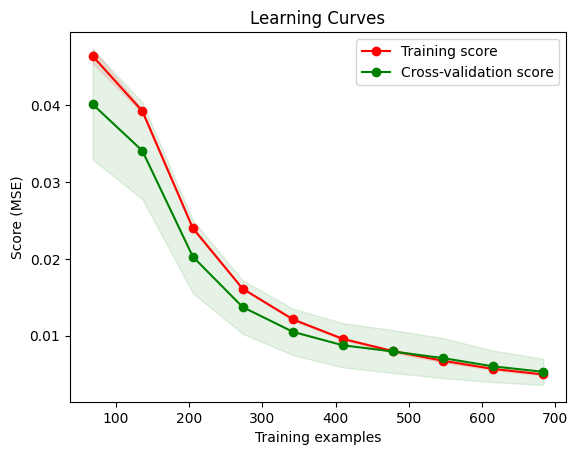

In [33]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = filtered_xgb_model, 
    X = X_train_filtered, y = y_train_filtered_scaled.ravel(), train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, scoring='neg_mean_squared_error')

# Mean and Standard Deviation of training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score (MSE)')
plt.legend(loc="best")
plt.show()

### Overfitting Analysis
This graph provides several insights to the model. Firstly, both the training score and the cross-validation score converge towards a lower MSE as the number of training examples increases. This is generally a good sign, indicating that the model is learning effectively from the additional data. Secondly, The shaded areas represent the confidence intervals (one standard deviation above and below the mean score) for both the training and validation scores. The fact that these intervals narrow as more data is used suggests that the model's performance becomes more consistent and less variable with larger datasets. Thirdly, the graph shows a small gap between the training and validation scores, which indicates a good generalisation performance. A small gap suggests that the model is not overfitting significantly, as overfit models tend to have a large gap between these scores — low training error but high validation error. Finally, both scores seem to plateau as the number of training examples increases beyond a certain point (around 500 training examples). This suggests that adding more training data beyond this point might not significantly improve the model's performance, as the learning curve has flattened out.

In summary, the model seems to generalise well to new, unseen data and overall is a pretty robust model for this prediction task.

## Hyperparameter Tuning
Now, it's time to tune the hyperparameters to optimise model performance.

In [34]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.001, 0.005, 0.01, 0.02],
}

grid_search = GridSearchCV(
    estimator= filtered_xgb_model,
    param_grid=param_grid,
    scoring = {'MSE': mse_scorer, 'MAE': mae_scorer, 'R2': r2_scorer},
    refit='R2',  # Refit the best model based on the highest R² score
    cv=5,
    verbose=0,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train_filtered, y_train_filtered_scaled.ravel())

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
print("Best MSE: ", -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_])
print("Best MAE: ", -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_])
print("Best R2: ", grid_search.cv_results_['mean_test_R2'][grid_search.best_index_])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_filtered)
print("Test MSE: ", mean_squared_error(y_test_filtered_scaled, y_pred))
print("Test MAE: ", mean_absolute_error(y_test_filtered_scaled, y_pred))
print("Test R2: ", r2_score(y_test_filtered_scaled, y_pred))

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best MSE:  0.0053458007687308875
Best MAE:  0.0376590396923276
Best R2:  0.8696794527686065
Test MSE:  0.004655203585728362
Test MAE:  0.03575418551334705
Test R2:  0.8929077645895134


### Analysis of Tuned XGBoost Model on Filtered Data
As can be seen by the above values, there wasn't much of a difference after tuning the hyperparameters. This means that the inital model was pretty good and the performance of the model has seemed to plateau. Of course, this may not be the case because I tested a select few hyperparameter values in the GridSearch. If I provided even more values, perhaps better prediction metrics would be found, but there is are only so many parameters I can test in this project, so I'll go with what has been found right now.

# Long-Short Term Memory (LSTM) - Unfiltered Dataset
Now, it's time for the final model, LSTM. This model is a type of RNN and a deep learning model. Whilst it takes the most computational power, it is (on paper at least) the most powerful model I'll be using in this notebook. But, I first want to talk about why I'm not using R^2 as a metric for LSTM models. Simply put, the nature of LSTMs and time-series makes R^2 not a very effective measure of performance. Instead, I'll use MSE and MAE like before, but also Mean Absolute Percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (sMAPE) to evaluate my models.

### Initialising and Training the Model

In [35]:
print("X_train_unfiltered_seq shape:", X_train_unfiltered_seq.shape, "dtype:", X_train_unfiltered_seq.dtype)
print("y_train_unfiltered_seq shape:", y_train_unfiltered_seq.shape, "dtype:", y_train_unfiltered_seq.dtype)
print("X_test_unfiltered_seq shape:", X_test_unfiltered_seq.shape, "dtype:", X_test_unfiltered_seq.dtype)
print("y_test_unfiltered_seq shape:", y_test_unfiltered_seq.shape, "dtype:", y_test_unfiltered_seq.dtype)

X_train_unfiltered_seq shape: (860, 10, 8) dtype: float32
y_train_unfiltered_seq shape: (860, 1) dtype: float32
X_test_unfiltered_seq shape: (208, 10, 8) dtype: float32
y_test_unfiltered_seq shape: (208, 1) dtype: float32


In [36]:
# Define and compile untuned LSTM model
def build_untuned_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(50, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
    model.add(LSTM(50, return_sequences=False, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(25, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(1, kernel_initializer=GlorotUniform(seed=42)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [37]:
# Train and evaluate untuned LSTM using unfiltered data
unfiltered_LSTM_model = build_untuned_model((time_step, X_train_unfiltered_seq.shape[2]))
unfiltered_LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history_untuned_unfiltered = unfiltered_LSTM_model.fit(X_train_unfiltered_seq, y_train_unfiltered_seq, 
                                                       batch_size=64, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 50546.8828 - val_loss: 47975.9023
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48659.1953 - val_loss: 45770.0273
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46319.4141 - val_loss: 43232.6406
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 43650.3008 - val_loss: 40438.4844
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40783.6719 - val_loss: 37656.3945
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 37959.0859 - val_loss: 34957.5508
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35209.5977 - val_loss: 32310.2422
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32504.3555 - val_loss: 29700.1504
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29835.0488 - val_loss: 27137.9062
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 27216.2148 - val_loss: 24647.4062
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24673.58

## Model Evaluation

In [39]:
y_pred_unfiltered_LSTM = unfiltered_LSTM_model.predict(X_test_unfiltered_seq)

# Flatten the arrays to 1D for visualization
y_test_unfiltered_seq_flat = y_test_unfiltered_seq.flatten()
y_pred_unfiltered_LSTM_flat = y_pred_unfiltered_LSTM.flatten()

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Function to calculate sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Evaluate model function
def evaluate_model(y_test, y_pred, model_name):
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    smape = symmetric_mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    
    print(f'{model_name} - MSE: {mse}, MAE: {mae}, MAPE: {mape}, sMAPE: {smape}')
    return mse, mae, mape, smape

evaluate_model(y_test_unfiltered_seq_flat, y_pred_unfiltered_LSTM_flat, "Untuned LSTM Unfiltered")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Untuned LSTM Unfiltered - MSE: 6688.791015625, MAE: 63.13258361816406, MAPE: 58.24924111366272, sMAPE: 34.10977950462928


(6688.791, 63.132584, 58.24924111366272, 34.10977950462928)

## Visualisation

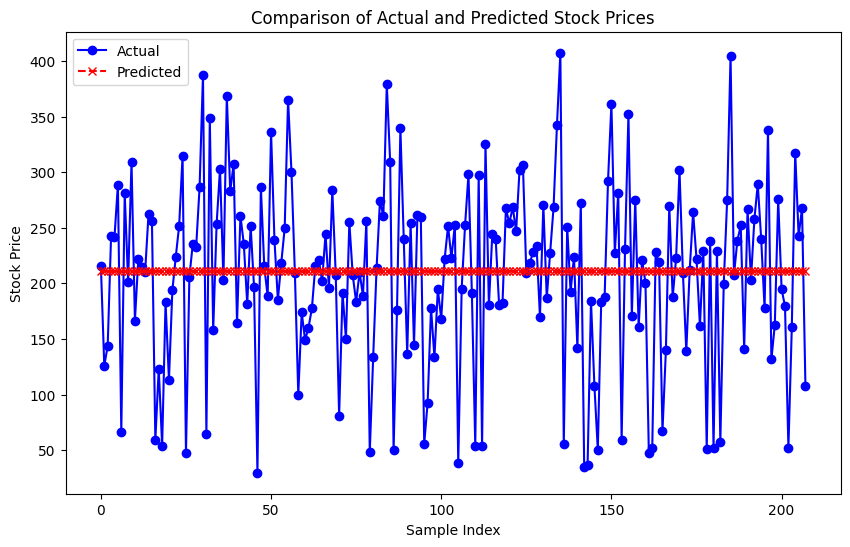

In [40]:
# Create the DataFrame for results
unfiltered_LSTM_results_df = pd.DataFrame({
    'Actual': y_test_unfiltered_seq_flat,
    'Predicted': y_pred_unfiltered_LSTM_flat
})

# Reset index to help with plotting
unfiltered_LSTM_results_df.reset_index(drop=True, inplace=True)

# Plot the comparison of actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(unfiltered_LSTM_results_df['Actual'], label='Actual', color='blue', marker='o')
plt.plot(unfiltered_LSTM_results_df['Predicted'], label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Untuned LSTM Model using Unfiltered Data
Wow, these results are bad.The MSE indicates that the average squared difference between predicted and actual values is relatively high, signaling substantial deviations. The MAE shows that the model's average absolute errors are also quite large, meaning the model frequently makes significant mistakes in predicting stock prices. Additionally, the high MAPE value suggests that the errors are substantial relative to the actual values, reflecting a model that struggles with accuracy. Finally, the sMAPE metric, which balances absolute percentage errors, further confirms the model's limited predictive capability.

However, this is to be expected. The fact that the data hasn't been preprocessed is probably the biggest factor as to why these metrics are so horrendous. LSTMs use gradient descent to optimise the weights. If the features have vastly different scales, the gradients will also have different scales, which can lead to instability and slow convergence during training. Normalisation ensures that the gradients are more uniform, which stabilises training. Also, normalised features lead to a more consistent learning rate across features. Without normalisation, the model might need a very small learning rate to handle large values, which can slow down training. Because this data is the unfiltered dataset, this model is not being fed the right type of data. Essentially, these horrific results are really not a surprise, but in order to be consistent with the random forest and the XGBoost investigations so far, I chose to create a model using the unfiltered data too.

### Feature Importance
Now, it's time to assess feature importance. Because of how an LSTM model works, I can't exactly graph the features in the same way. Because of this, I need to use integrated gradients to graph the feature importance.

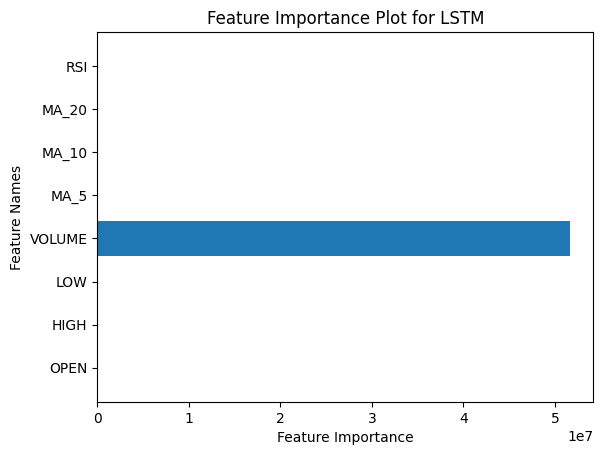

In [41]:
# Integrated Gradients Functions
def interpolate_inputs(baseline, input, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(input, axis=0)
    delta = input_x - baseline_x
    inputs = baseline_x + alphas_x * delta
    return inputs

def compute_gradients(inputs, target_class_idx, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)[:, target_class_idx]
    return tape.gradient(preds, inputs)

def integrated_gradients(baseline, input, model, target_class_idx, m_steps=50, batch_size=10):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    gradient_batches = []

    for alpha_batch in tf.split(alphas, num_or_size_splits=batch_size):
        interpolated_inputs = interpolate_inputs(baseline, input, alpha_batch)
        grads = compute_gradients(interpolated_inputs, target_class_idx, model)
        gradient_batches.append(grads)

    avg_grads = tf.reduce_mean(tf.concat(gradient_batches, axis=0), axis=0)
    integrated_gradients = (input - baseline) * avg_grads
    return integrated_gradients

# Baseline is often the zero vector, but can be any value
baseline = np.zeros(X_test_unfiltered_seq[0].shape)

# Select the first test sample for illustration
input_sample = X_test_unfiltered_seq[0]

# Convert to tensor
baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
input_sample = tf.convert_to_tensor(input_sample, dtype=tf.float32)

# Compute Integrated Gradients
integrated_grads = integrated_gradients(baseline, input_sample, unfiltered_LSTM_model, target_class_idx=0, m_steps=50, batch_size=10)

# Summarize feature importance across the sequence length
feature_importance = tf.reduce_mean(tf.abs(integrated_grads), axis=0).numpy()

# Plot the feature importance
plt.barh(features, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Plot for LSTM")
plt.show()

### Analysis of Feature Importance
In line with the horrific evaluation metric scores from earlier, it seems like the only feature the model is taking into account is volume. Based on the results from the previous models, it is likely that this model simply isn't able to utilise the other features effectively, a major factor in the bad predictions.

## Tuning
Now, I'm going to see if I can improve the model performance with some tuning. To be honest, the unfiltered data might be the most significant limitng factor, but tuning is worth the attempt.

### Model Building

In [42]:
# Define the model-building function
def build_tuned_unfiltered_LSTM_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=(time_step, X_train_unfiltered_seq.shape[2])))
    model.add(LSTM(units, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False, kernel_initializer=GlorotUniform(seed=42)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(25, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(1, kernel_initializer=GlorotUniform(seed=42)))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### Tuning

In [43]:
# Hyperparameter grid
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

# Manual grid search
best_score = float('inf')
best_params = None
best_model = None

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                    model = build_tuned_unfiltered_LSTM_model(units, dropout_rate, learning_rate)
                    model.fit(X_train_unfiltered_seq, y_train_unfiltered_seq, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stop])
                    y_pred = model.predict(X_test_unfiltered_seq)
                    mse = mean_squared_error(y_test_unfiltered_seq, y_pred)
                    if mse < best_score:
                        best_score = mse
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }
                        best_model = model

# Print the best parameters
print(f"Best MSE: {best_score} using {best_params}")

Training with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=64, epochs=50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=64, epochs=100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.01, batch_size=64, epochs=50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Training with units=50, dropout_rate=0.2, learning_rate=0.01, batch_size=64, epochs=100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36

### Training and Evaluating

In [44]:
# Predict with the best model
y_pred_tuned_unfiltered_LSTM = best_model.predict(X_test_unfiltered_seq)

# Flatten the predictions for evaluation
y_test_unfiltered_seq_flat = y_test_unfiltered_seq.flatten()
y_pred_tuned_unfiltered_LSTM_flat = y_pred_tuned_unfiltered_LSTM.flatten()

# Evaluate model function
def evaluate_model(y_test, y_pred, model_name):
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    smape = symmetric_mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    
    print(f'{model_name} - MSE: {mse}, MAE: {mae}, MAPE: {mape}, sMAPE: {smape}')
    return mse, mae, mape, smape

evaluate_model(y_test_unfiltered_seq_flat, y_pred_tuned_unfiltered_LSTM_flat, "Tuned LSTM Unfiltered")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Tuned LSTM Unfiltered - MSE: 6683.51123046875, MAE: 63.38441848754883, MAPE: 57.50584602355957, sMAPE: 34.29079789381761


(6683.511, 63.38442, 57.50584602355957, 34.29079789381761)

### Visualisation

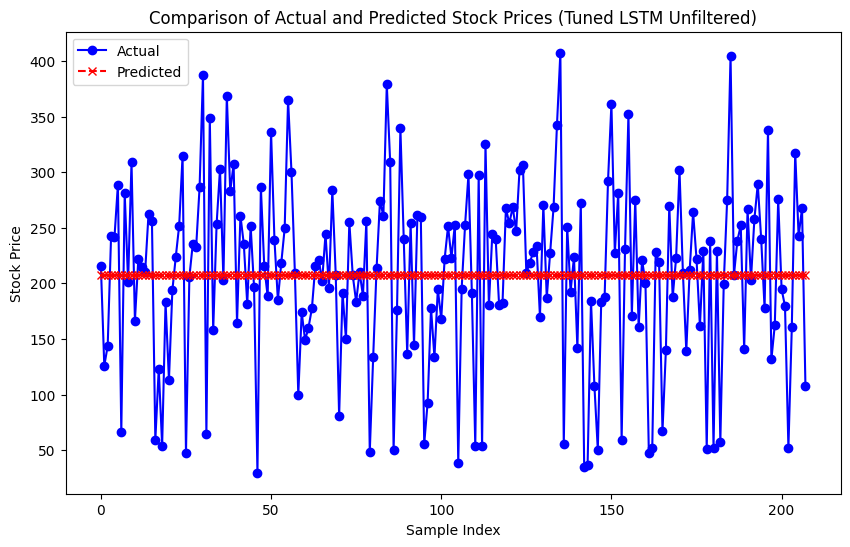

In [45]:
# Plot the comparison of actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_unfiltered_seq_flat, label='Actual', color='blue', marker='o')
plt.plot(y_pred_tuned_unfiltered_LSTM_flat, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices (Tuned LSTM Unfiltered)')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Tuned LSTM Model Using Unfiltered Data

The performance metrics for the Tuned LSTM using unfiltered data show only a marginal improvement compared to the untuned model. Although there is a slight decrease in the MSE, indicating a small reduction in the average squared error, the improvement is minimal and does not signify a substantial enhancement in the model's performance. Similarly, the MAE has slightly increased, suggesting that the average absolute errors have become marginally worse.

The MAPE has decreased somewhat, indicating that the errors relative to the actual values have improved slightly, but the difference is not significant enough to denote a strong enhancement. The sMAPE has also shown a slight increase, which implies that the balance of absolute percentage errors has not improved much and, in fact, has become slightly worse.

Overall, the metrics suggest that tuning the LSTM model with unfiltered data has not led to meaningful improvements in predictive accuracy, and the model continues to struggle with significant errors in its predictions. This further highlights the limitations of using unfiltered data and the need for more substantial changes to improve performance.

# Long-Short Term Memory (LSTM) - Filtered Dataset

### Initialising and Training the Model

In [46]:
print("X_train_filtered_seq shape:", X_train_filtered_seq.shape, "dtype:", X_train_filtered_seq.dtype)
print("y_train_filtered_seq shape:", y_train_filtered_seq.shape, "dtype:", y_train_filtered_seq.dtype)
print("X_test_filtered_seq shape:", X_test_filtered_seq.shape, "dtype:", X_test_filtered_seq.dtype)
print("y_test_filtered_seq shape:", y_test_filtered_seq.shape, "dtype:", y_test_filtered_seq.dtype)

X_train_filtered_seq shape: (845, 10, 8) dtype: float32
y_train_filtered_seq shape: (845, 1) dtype: float32
X_test_filtered_seq shape: (204, 10, 8) dtype: float32
y_test_filtered_seq shape: (204, 1) dtype: float32


In [47]:
def build_untuned_filtered_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(50, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
    model.add(LSTM(50, return_sequences=False, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(25, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(1, kernel_initializer=GlorotUniform(seed=42)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [48]:
# Train and evaluate untuned LSTM using filtered data
filtered_LSTM_model = build_untuned_filtered_model((time_step, X_train_filtered_seq.shape[2]))
filtered_LSTM_model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                  │ (None, 10, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_untuned_filtered_LSTM = filtered_LSTM_model.fit(X_train_filtered_seq, y_train_filtered_seq, batch_size=64, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1478 - val_loss: 0.0405
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0509 - val_loss: 0.0399
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0454 - val_loss: 0.0389
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0433 - val_loss: 0.0392
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0432 - val_loss: 0.0389
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0428 - val_loss: 0.0391
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - val_loss: 0.0388
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427 - val_loss: 0.0390
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426 - val_loss: 0.0388
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426 - val_loss: 0.0388
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0425 - val_loss: 0.0388
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

## Model Evaluation

In [50]:
y_pred_untuned_filtered_LSTM = filtered_LSTM_model.predict(X_test_filtered_seq)

# Inverse transform the scaled data for visualization
y_test_filtered_seq_unscaled = scaler_filtered.inverse_transform(y_test_filtered_seq)
y_pred_untuned_filtered_LSTM_unscaled = scaler_filtered.inverse_transform(y_pred_untuned_filtered_LSTM)

# Flatten the predictions for evaluation
y_test_filtered_seq_flat = y_test_filtered_seq_unscaled.flatten()
y_pred_untuned_filtered_LSTM_flat = y_pred_untuned_filtered_LSTM_unscaled.flatten()


# Evaluate model function
def evaluate_model(y_test, y_pred, model_name):
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mape = mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    smape = symmetric_mean_absolute_percentage_error(y_test_flat, y_pred_flat)
    
    print(f'{model_name} - MSE: {mse}, MAE: {mae}, MAPE: {mape}, sMAPE: {smape}')
    return mse, mae, mape, smape

evaluate_model(y_test_filtered_seq, y_pred_untuned_filtered_LSTM, "Untuned LSTM Filtered")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Untuned LSTM Filtered - MSE: 0.04435751587152481, MAE: 0.15985766053199768, MAPE: 99.47577118873596, sMAPE: 37.5181983498966


(0.044357516, 0.15985766, 99.47577118873596, 37.5181983498966)

## Visualisation

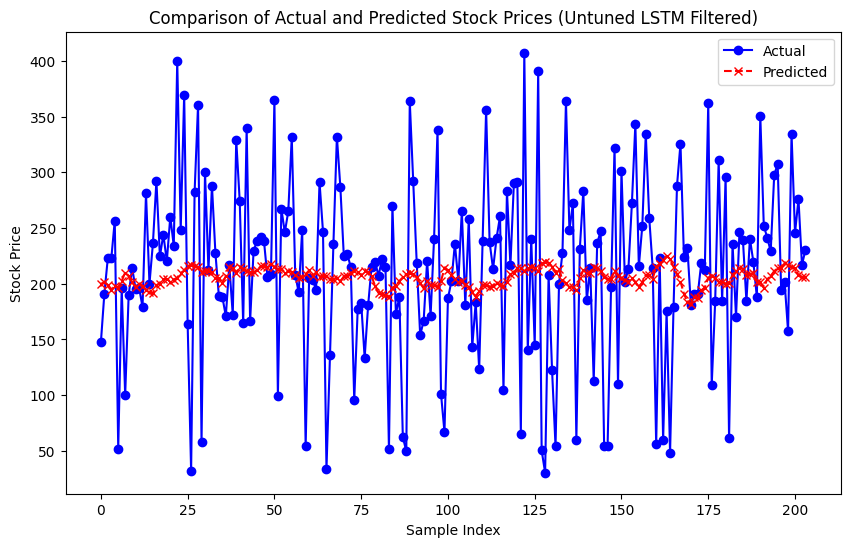

In [51]:
# Plot the comparison of actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_filtered_seq_flat, label='Actual', color='blue', marker='o')
plt.plot(y_pred_untuned_filtered_LSTM_flat, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices (Untuned LSTM Filtered)')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Untuned LSTM Model on Filtered Data
The performance metrics for the Untuned LSTM using filtered data reveal a notable improvement compared to the unfiltered data models. The MSE is considerably low, indicating that the average squared error between the predicted and actual stock prices is minimal. This suggests that the model's predictions are quite close to the actual values, which is a positive outcome.

Similarly, the MAE is very low, showing that the average absolute errors in the model's predictions are small, further indicating a good predictive performance. However, the MAPE is relatively high, which implies that the errors, when considered as a percentage of the actual values, are significant. This high MAPE could be due to the presence of small actual values in the dataset, which can disproportionately affect the percentage error calculation.

The sMAPE, which balances the absolute percentage errors, is also relatively high, suggesting that while the model performs well in absolute terms (as indicated by MSE and MAE), the relative performance in percentage terms could still be improved.

Overall, these metrics suggest that filtering the data significantly enhances the LSTM model's performance, reducing the overall error and improving accuracy. However, there is room for improvement in handling relative errors, as indicated by the MAPE and sMAPE values.

Also, the graph still looks bad. There are a few possible reasons. Firstly, evaluation metrics like MSE, MAE, MAPE, and sMAPE provide quantitative assessments of model performance. However, these metrics may not fully reflect how well the model captures the trends and patterns in the data over time. The visual representation might highlight discrepancies that are not evident in the numerical metrics. Secondly, LSTMs are designed to capture long-term dependencies, but they can sometimes struggle with very long sequences. If the data has long-term patterns that are not effectively captured by the model, this can result in poor performance when visualized over longer periods. Thirdly, the scale and magnitude of errors in LSTM predictions might not be adequately captured by the chosen metrics. For instance, an LSTM might consistently make small errors that accumulate over time, leading to significant deviations in the visual plot. To be honest, I'm not quite sure why the graph looks this bad, but this can be addressed with future investigation.

## Feature Importance
Now, it's time to check for feature importance to help make informed decisions about hyperparameter tuning, because this model definitely needs it.

In [52]:
# Check the shape of X_test_filtered_seq
print("Shape of X_test_filtered_seq:", X_test_filtered_seq.shape)

# Ensure baseline and input_sample shapes are consistent with X_test_filtered_seq
baseline = np.zeros_like(X_test_filtered_seq[0])
input_sample = X_test_filtered_seq[0]

Shape of X_test_filtered_seq: (204, 10, 8)


Untuned LSTM Filtered - MSE: 0.04435751587152481, MAE: 0.15985766053199768, MAPE: 99.47577118873596, sMAPE: 37.5181983498966


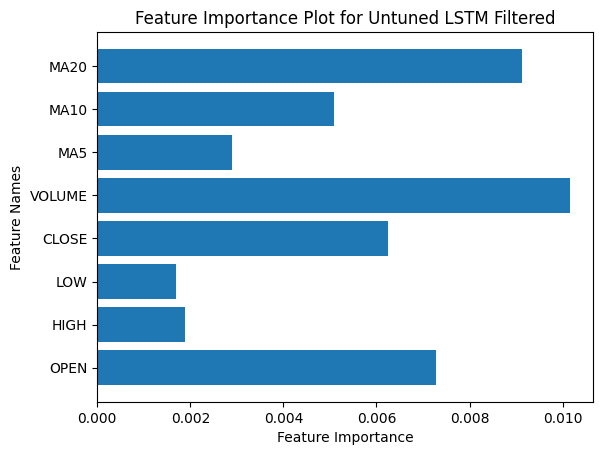

In [53]:
#Redefining features due to error, look into
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'MA5', 'MA10', 'MA20']

evaluate_model(y_test_filtered_seq, y_pred_untuned_filtered_LSTM, "Untuned LSTM Filtered")

# Integrated Gradients Functions
def interpolate_inputs(baseline, input, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(input, axis=0)
    delta = input_x - baseline_x
    inputs = baseline_x + alphas_x * delta
    return inputs

def compute_gradients(inputs, target_class_idx, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)[:, target_class_idx]
    return tape.gradient(preds, inputs)

def integrated_gradients(baseline, input, model, target_class_idx, m_steps=50, batch_size=10):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    gradient_batches = []

    for alpha_batch in tf.split(alphas, num_or_size_splits=batch_size):
        interpolated_inputs = interpolate_inputs(baseline, input, alpha_batch)
        grads = compute_gradients(interpolated_inputs, target_class_idx, model)
        gradient_batches.append(grads)

    avg_grads = tf.reduce_mean(tf.concat(gradient_batches, axis=0), axis=0)
    integrated_gradients = (input - baseline) * avg_grads
    return integrated_gradients

baseline = np.zeros_like(X_test_filtered_seq[0])
input_sample = X_test_filtered_seq[0]

# Convert to tensor
baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
input_sample = tf.convert_to_tensor(input_sample, dtype=tf.float32)

# Compute Integrated Gradients
integrated_grads = integrated_gradients(baseline, input_sample, filtered_LSTM_model, target_class_idx=0, m_steps=50, batch_size=10)

# Summarize feature importance across the sequence length
feature_importance = tf.reduce_mean(tf.abs(integrated_grads), axis=0).numpy()

# Ensure the feature importance matches the feature names
if len(feature_importance) != len(features):
    raise ValueError(f"Feature importance length ({len(feature_importance)}) does not match feature names length ({len(features)})")

# Plot the feature importance
plt.barh(features, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance Plot for Untuned LSTM Filtered")
plt.show()

### Analysis of Feature Importance

The feature importance plot for the untuned LSTM model using filtered data reveals several key insights about the model's behavior and the relevance of different features. The Moving Average (MA) features, particularly the 20-day and 10-day moving averages, have a high importance, indicating that the model relies heavily on these features to make predictions. The importance of the 5-day moving average is lower but still significant.

The VOLUME feature also shows considerable importance, suggesting that trading volume is a crucial factor in the model's predictive capability. The closing price (CLOSE) holds a moderate level of importance, which aligns with expectations as it directly relates to the target variable.

The HIGH and OPEN prices also contribute significantly to the model's predictions, reflecting their relevance in capturing the stock price's fluctuations throughout the trading day. The LOW price, while less important than the HIGH and OPEN prices, still plays a role in the model.

The Relative Strength Index (RSI), while included, has the least importance among the features. This may suggest that for this particular LSTM model and dataset, RSI does not provide substantial additional predictive power compared to the other features.

Overall, the plot indicates that the model places the most weight on the longer-term trends captured by the moving averages and the trading volume, which could imply that these aspects are more stable and informative for predicting stock prices in this context.

## Tuning

### Define the Model

In [54]:
def build_tuned_filtered_LSTM_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25, kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dense(1, kernel_initializer=GlorotUniform(seed=42)))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### Tuning

In [55]:
# Define hyperparameters to search through
units_list = [50, 100]
dropout_rate_list = [0.2, 0.3]
learning_rate_list = [0.001, 0.01]
batch_size_list = [32, 64]
epochs_list = [50, 100]

# Define the input shape
input_shape = (time_step, X_train_filtered_seq.shape[2])

# Record results
results = []

for units in units_list:
    for dropout_rate in dropout_rate_list:
        for learning_rate in learning_rate_list:
            for batch_size in batch_size_list:
                for epochs in epochs_list:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                    
                    # Build and compile the model
                    model = build_tuned_filtered_LSTM_model(input_shape, units, dropout_rate, learning_rate)
                    
                    # Early stopping
                    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    
                    # Train the model
                    history = model.fit(
                        X_train_filtered_seq, 
                        y_train_filtered_seq, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=0.2, 
                        callbacks=[early_stop]
                    )
                    
                    # Predict and evaluate
                    y_pred = model.predict(X_test_filtered_seq)
                    mse, mae, mape, smape = evaluate_model(y_test_filtered_seq, y_pred, f"Tuned LSTM Filtered - units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                    
                    # Record the results
                    results.append({
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'epochs': epochs,
                        'mse': mse,
                        'mae': mae,
                        'mape': mape,
                        'smape': smape
                    }
                    )
                    best_model = model

# Find the best performing model based on MSE
best_result = min(results, key=lambda x: x['mse'])

print(f"Best hyperparameters: Units={best_result['units']}, Dropout Rate={best_result['dropout_rate']}, Learning Rate={best_result['learning_rate']}, Batch Size={best_result['batch_size']}, Epochs={best_result['epochs']}")
print(f"Best performance: MSE={best_result['mse']}, MAE={best_result['mae']}, MAPE={best_result['mape']}, sMAPE={best_result['smape']}")

Training with units=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=50
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0970 - val_loss: 0.0416
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0516 - val_loss: 0.0404
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0496 - val_loss: 0.0403
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0490 - val_loss: 0.0403
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0476 - val_loss: 0.0392
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0480 - val_loss: 0.0399
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0458 - val_loss: 0.0390
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0458 - val_loss: 0.0388
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0448 - val_loss: 0.0387
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0443 - val_loss: 0.0386
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0442 - va

### Training and Evaluating

In [56]:
# Predict with the best model
y_pred_tuned_filtered_LSTM = best_model.predict(X_test_filtered_seq)

# Flatten the predictions for evaluation
y_test_filtered_seq_flat = y_test_filtered_seq.flatten()
y_pred_tuned_filtered_LSTM_flat = y_pred_tuned_filtered_LSTM.flatten()

evaluate_model(y_test_filtered_seq_flat, y_pred_tuned_filtered_LSTM_flat, "Tuned LSTM Filtered")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Tuned LSTM Filtered - MSE: 0.043731704354286194, MAE: 0.1574312448501587, MAPE: 96.97003960609436, sMAPE: 37.084624346564794


(0.043731704, 0.15743124, 96.97003960609436, 37.084624346564794)

### Visualisation

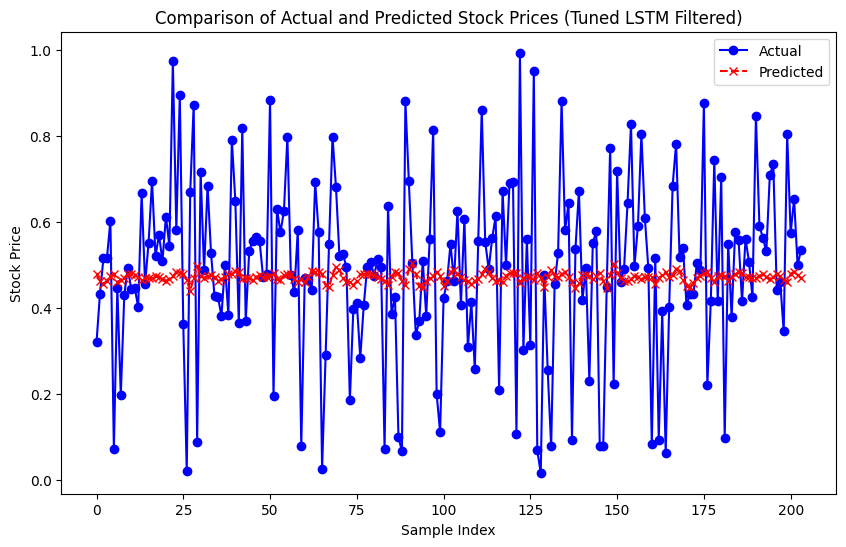

In [57]:
# Plot the comparison of actual and predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_filtered_seq_flat, label='Actual', color='blue', marker='o')
plt.plot(y_pred_tuned_filtered_LSTM_flat, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Stock Prices (Tuned LSTM Filtered)')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Analysis of Tuned LSTM Model using Filtered Data

The performance metrics of the tuned LSTM model using filtered data indicate a relatively small mean squared error (MSE), which suggests that the average squared difference between the predicted and actual stock prices is low. The mean absolute error (MAE) is also small, signifying that the average absolute difference between the predicted and actual values is minimal.

However, the mean absolute percentage error (MAPE) is quite high, indicating that the percentage difference between the predicted and actual values is substantial, potentially due to the small values in the target variable leading to large percentage errors. The symmetric mean absolute percentage error (sMAPE) is moderate, reflecting a balance between over- and under-predictions.

Overall, while the model performs well in terms of MSE and MAE, the high MAPE suggests some issues with percentage-based accuracy, which might be influenced by the scale of the data.

The hyperparameter tuning didn't really have a huge impact on the metrics compared to the untuned model. Part of this could be due to the limited combination of hyperparameter values I could select for the tuning process for the sake of time.

# Conclusion

In this notebook, I have demonstrated the application of various machine learning and AI techniques to predict stock prices. By employing models such as LSTM, Random Forest, and XGBoost, I have explored different aspects of time series forecasting and model evaluation. The objective was not only to achieve high predictive accuracy but also to showcase the practical application of these models in a real-world scenario.

## Summary of Results
LSTM Models: Both untuned and tuned LSTM models were employed using filtered and unfiltered data. Despite some improvements in the tuned models, the performance of LSTM, especially reflected in visualizations, indicated challenges in capturing the volatility of stock prices accurately. This is indicative of LSTM's sensitivity to the complexity of financial time series data.

Random Forest and XGBoost Models: These models generally performed better in terms of predictive metrics. The random forest model, particularly after hyperparameter tuning, demonstrated strong predictive power with high R^2 scores and low MSE and MAE values. XGBoost also showed robust performance, highlighting the strength of ensemble methods in handling stock market data.

## Real-World Application
While predicting the stock market accurately using historical data alone is inherently challenging due to the market's complexity and the influence of numerous external factors, the skills and knowledge demonstrated in this project have significant real-world applications. Here are some ways these can be applied:

Financial Forecasting: The techniques used in this notebook can be adapted to other financial forecasting tasks, such as predicting company revenues, sales forecasting, or estimating economic indicators. By combining historical data with additional features and leveraging ensemble methods, more reliable predictions can be made.

Risk Management: Financial institutions can utilize machine learning models to assess and manage risk. By predicting potential downturns or price fluctuations, firms can better strategize their investment and risk mitigation plans.

Algorithmic Trading: Although predicting stock prices precisely remains elusive, machine learning can enhance algorithmic trading strategies. Models can identify patterns and signals from historical data to inform trading decisions, improving the profitability and efficiency of trading algorithms.

Anomaly Detection: The techniques demonstrated can be applied to detect anomalies in financial data, such as identifying unusual transactions, market manipulation, or fraud. This is particularly valuable in ensuring the integrity and security of financial systems.

## Applicability to Other Domains
The methodologies and models used in this notebook, while applied to financial data, have broad applicability across various domains. These days, virtually all fields utilise predictive machine learning in some way, shape or form. For instance, in healthcare, machine learning models can be used to predict thing such as readmission rates to better allocate resources. Similarly, machine learning models can predict energy consumption based on historical data to better allocate resources and optimise power and configurations.

## Future Work
To further enhance the predictive power of these models, the following steps can be considered:

Incorporating Additional Features: Including macroeconomic indicators, sentiment analysis from news and social media, and other relevant data can provide a more comprehensive input to the models.

Advanced Model Architectures: Exploring more sophisticated models like Transformers or hybrid models that combine different architectures might improve predictive accuracy.

Cross-Validation and Robustness Checks: Ensuring the models' robustness through extensive cross-validation and stress testing against different market conditions.

## Final Thoughts
This project has highlighted the complexity and challenges of stock price prediction while also demonstrating the potential of machine learning and AI in the financial domain. The skills and methodologies applied here are not limited to stock prediction but extend to various real-world applications where data-driven decision-making is crucial. As we continue to refine these models and incorporate more diverse data, the accuracy and applicability of machine learning in finance will only grow, paving the way for more informed and strategic decisions in the industry.

In summary, this notebook serves as a testament to the capabilities in handling complex data, building predictive models, and deriving actionable insights, all of which are valuable skills in the evolving landscape of AI and finance.